In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.layers import Dense

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data pre-filtered offline, see 'filtering.ipynb'
# This data frame contains LA county only, age between 18 and 60 (working class)
# Data shape is (670787, 38)
df = pd.read_csv('/content/drive/Shareddrives/DSCI531/modeling/filtered.csv')
df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEICP,COUNTYICP,STRATA,GQ,...,EMPSTAT,EMPSTATD,UHRSWORK,INCWAGE,DIFFREM,DIFFPHYS,DIFFEYE,DIFFHEAR,VETSTAT,VETSTATD
0,2010,201001,70077,71,59.0,2010000700771,71,370,610306,1,...,1,10,30,8000,1,1,1,1,1,11
1,2010,201001,70077,71,59.0,2010000700771,71,370,610306,1,...,3,30,0,0,1,1,1,1,1,11
2,2010,201001,70078,73,75.0,2010000700781,71,370,610406,1,...,3,30,0,0,2,1,1,1,1,11
3,2010,201001,70078,73,75.0,2010000700781,71,370,610406,1,...,3,30,40,38000,1,1,1,1,1,13
4,2010,201001,70087,131,55.0,2010000700871,71,370,570106,1,...,1,10,40,9700,1,1,1,1,1,11


# Step 1: scale the income
Due to the inflation, predicting directly the income level is not accurate or meaningful at all. We use a yearly income index assigned to each census data poing. The formula is: income/avg_income_of_the_year. This index minimizes the impact of inflation rate and the impact of currency.

For this index, 1 means a person's income is at the year's average level, below 1 means the person is under the average level, and above 1 means the person is above average level. This will be a very straight-forward indication of the income level of a data point (person).

In [5]:
yearly_inc_avg = df.groupby(['YEAR'],
                            as_index = False)\
                            .agg({'INCWAGE':'mean'})\
                            .rename(columns = {'INCWAGE':'INC_AVG'})
yearly_inc_avg

,YEAR,INC_AVG
0,2010,30823.763087
1,2011,29283.865254
2,2012,30208.515870
3,2013,31436.903442
4,2014,32700.228003
5,2015,33947.369810
6,2016,35832.774870
7,2017,37794.629489
8,2018,39669.981687
9,2019,42336.581736


In [15]:
new_df = pd.merge(left = df, right = yearly_inc_avg, how = 'left', on = 'YEAR')
new_df['INC_INDEX'] = new_df['INCWAGE']/new_df['INC_AVG']
new_df['INC_INDEX'] = new_df['INC_INDEX'].apply(lambda x: 1 if x>=1 else 0)
new_df

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEICP,COUNTYICP,STRATA,GQ,...,UHRSWORK,INCWAGE,DIFFREM,DIFFPHYS,DIFFEYE,DIFFHEAR,VETSTAT,VETSTATD,INC_AVG,INC_INDEX
0,2010,201001,70077,71,59.0,2010000700771,71,370,610306,1,...,30,8000,1,1,1,1,1,11,30823.763087,0
1,2010,201001,70077,71,59.0,2010000700771,71,370,610306,1,...,0,0,1,1,1,1,1,11,30823.763087,0
2,2010,201001,70078,73,75.0,2010000700781,71,370,610406,1,...,0,0,2,1,1,1,1,11,30823.763087,0
3,2010,201001,70078,73,75.0,2010000700781,71,370,610406,1,...,40,38000,1,1,1,1,1,13,30823.763087,1
4,2010,201001,70087,131,55.0,2010000700871,71,370,570106,1,...,40,9700,1,1,1,1,1,11,30823.763087,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670782,2019,201901,1189366,2019001412197,133.0,2019011893661,54,370,250347,2,...,40,24000,1,1,1,1,1,11,42336.581736,0
670783,2019,201901,1189366,2019001412197,133.0,2019011893661,54,370,250347,2,...,40,31800,1,1,1,1,1,11,42336.581736,0
670784,2019,201901,1189366,2019001412197,133.0,2019011893661,54,370,250347,2,...,40,27000,1,1,1,1,1,11,42336.581736,0
670785,2019,201901,1189366,2019001412197,133.0,2019011893661,54,370,250347,2,...,25,8800,1,1,1,1,1,11,42336.581736,0


# Codings:

SEX:

1 male
2 female

FERTYR:
0 N/A
1 No
2 Yes

impute N/A

MARST: 

1	Married, spouse present	
2	Married, spouse absent
3	Separated	
4	Divorced	
5	Widowed	
6	Never married/single

RACE:

1	White	
2	Black/African American/Negro
3	American Indian or Alaska Native
4	Chinese	
5	Japanese
6	Other Asian or Pacific Islander	
7	Other race, nec	
8	Two major races	
9	Three or more major races

BLP and BLPD:

we need to clean it as born in california or not in california. California BLP code is 006

CITIZEN:

0	N/A	
1	Born abroad of American parents	
2	Naturalized citizen	
3	Not a citizen
4	Not a citizen, but has received first papers (0 cases)
5	Foreign born, citizenship status not reported	(0 case)
8	Illegible (0 case)
9	Missing/blank (0 case)

YRSUSA1: years in the US

SPEAKING:

0	N/A or blank
2	Yes, speaks English (0 case)
3	Yes, speaks only English
4	Yes, speaks very well
5	Yes, speaks well
6	Yes, but not well

Impute N/A

HCOVANY:

1	No health insurance coverage
2	With health insurance coverage

EDUCD:

001	N/A
002	No schooling completed
011	Nursery school, preschool	
012	Kindergarten
014	Grade 1
015	Grade 2	
016	Grade 3	
017	Grade 4	
022	Grade 5
023	Grade 6	
025	Grade 7	
026	Grade 8
030	Grade 9
040	Grade 10	
050	Grade 11	
061	12th grade, no diploma
063	Regular high school diploma
064	GED or alternative credential
065	Some college, but less than 1 year
071	1 or more years of college credit, no degree
081	Associate's degree, type not specified
101	Bachelor's degree	
110	5+ years of college
114	Master's degree
115	Professional degree beyond a bachelor's degree
116	Doctoral degree

we will clean this data to 'N/A => impute', 'No school, unifinished = 0', 'high school diploma = 1', 'associate degree = 2', 'bachelor = 3', 'masters = 4', 'doctoral = 5'

SCHLTYPE:

0	N/A
1	Not enrolled
2	Public school
3	Private school (1960,1990-2000, ACS, PRCS)

Impute N/A

EMPSTAT:

0	N/A
1	Employed
2	Unemployed
3	Not in labor force

Filter Not in labor force, because we study the group with ability to work

Impute N/A

UHRSWORK

Numeric hours work per week

00 = N/A, impute

DIFFREM: Cognitive disability

0	N/A
1	No cognitive difficulty
2	Has cognitive difficulty

impute N/A


DIFFPHYS: ambulatory disability

0	N/A
1	No ambulatory difficulty
2	Has ambulatory difficulty	

Impute N/A


DIFFEYE

1	No
2	Yes


DIFFHEAR

1	No
2	Yes


VETSTAT
0	N/A
1	Not a veteran
2	Veteran

Impute N/A

# More Filtering

EMPSTAT != 3

In [16]:
# filtering
new_df = new_df[new_df['EMPSTAT'] != 3]
# Spliting X and y
X = new_df

# Features with N/A imputation decisions:

FERTYR 0 (Only impute females values), CITIZEN 0, SPEAKING 0, EDUCD 001, SCHLTYPE 0, EMPTSTAT 0, UHRSWORK 00, DIFFREM:= 0, DIFFPHYS 0, VETSTAT 0 

In [17]:
from sklearn.impute import SimpleImputer

## FERTYR
We need to be careful that here, a male does not have the ability to give birth to a child, so we impute the N/A terms ONLY for female. We will make this categorical feature to a numeric one that ranges from 0 to 1. The lower means less concern on the child birth issues. Thus, for a solid "NO" reponse from a female, we will set it to 0, and a "YES" will be set to 1. Then we impute the female 'N/A' term with an average value within female group. Male should be absolute 0.

In [18]:
female_X = X[X['SEX'] == 2]
male_X = X[X['SEX'] == 1]

# First replace N/A term with a big number
female_X['FERTYR'] = female_X['FERTYR'].replace(0, 5)

# Then set "no birth given" to 0, same as male, Given birth become 1, and N/A becomes 4
female_X['FERTYR'] -= 1
# female_X['FERTYR'].hist()

# Assign mean value to the N/A terms, N/A becomes somewhere between 0 and 1
imp = SimpleImputer(missing_values= 4, strategy = 'mean')
female_X['FERTYR'] = imp.fit_transform(female_X[['FERTYR']])

female_X['FERTYR'].describe()
# female_X['FERTYR'].unique()

# Concat male and female
X = pd.concat([female_X,male_X])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

## Citizen
Referring to this forum https://forum.ipums.org/t/what-is-the-meaning-of-n-a-in-the-citizen-wkswork2-empstat-variables-on-the-2012-acs/495

N/A term here should be 'Citizen' due to protected reasons. Thus, we assign 0, 1, 2 as 1 (is citizen), and 3 as 0 (not a citizen) to make this feature a boolean variable.

In [19]:
X['CITIZEN'] = [1 if x ==0 or x == 1 or x == 2 else 0 for x in X['CITIZEN']]

## SPEAKENG
For language speaking, 0 is na (no case), 1 is does not speak english, 3 is speaks only english, 4 is speaks very well, 5 is speaks well, 6 is not well. We change this variable into a english speaking index. We set 0 as does not speak english, 1 as not well, 2 as well, 3 as very well and only english.

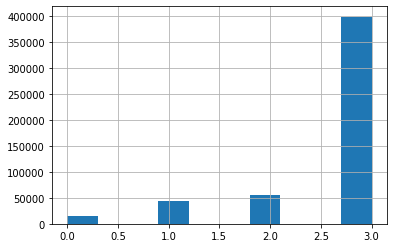

In [20]:
# Make a dictionary for replacing value
eng_dict = {1 : 0, 6 : 1, 5 : 2, 4 : 3, 3 : 3}

# Replace the value
X['SPEAKENG'] = [eng_dict[x] for x in X['SPEAKENG']]
# Inspect the values
X['SPEAKENG'].hist()

## EDUCD
There is no N/A terms in 'EDUCD' but we want to change some values because the current values are quite messy.

We will split this feature into 2, one is EDU_ATT - education attainment to show what level of education a person has received, and another feature we name 'DIPLOMA' to show what diploma a person has received. 

We set the following for EDU_ATT
- No school 002 => 0
- preschool & kindergarten 011, 012 => 1
- Attended elementary school (grades 1 to 5) [014 => 022] => 2
- Attended middle school (grades 6 to 8) [023 => 026] => 3
- Attended  high school (grades 9 to 12) [030 => 64] => 4
- Attended college [065 => 110] => 5
- Attended master or professional extension program [114 => 115] => 6
- Attended doctoral 116 => 7

In the questionaire, it asks: "11. What is the highest degree or level of school this person has COMPLETED? Mark (X) ONE box. If currently enrolled, mark the previous grade or highest degree received."

We set the following for DIPLOMA
- No diploma <= 61 => 0
- Highschool [63 => 71] and 110 => 1
- Associate 81 => 2
- Bachelor 101 => 3
- Master's and professional extension [114 => 115] => 4
- Doctoral 116 => 5

In [21]:
print(sorted(X['EDUCD'].unique()))

[2, 11, 12, 14, 15, 16, 17, 22, 23, 25, 26, 30, 40, 50, 61, 63, 64, 65, 71, 81, 101, 114, 115, 116]


In [22]:
edu_dict = {2 : 0, 
            11 : 1, 12: 1, 
            14:2, 15:2, 16:2, 17:2, 22:2, 
            23:3, 25:3, 26:3, 
            30:4, 40:4, 50:4, 61:4 , 63:4 , 64:4, 
            65:5, 71:5, 81:5, 101:5, 
            114:6, 115:6, 
            116:7}

dip_dict = {2 : 0, 11 : 0, 12: 0, 14:0, 15:0, 16:0, 17:0, 22:0,23:0, 25:0, 26:0, 
            30:0, 40:0, 50:0, 61:0 , 
            63:1 , 64:1, 65:1, 71:1, 
            81:2, 
            101:3, 
            114:4, 115:4, 
            116:5}
X['EDU_ATT'] = [edu_dict[x] for x in X['EDUCD']]
X['DIPLOMA'] = [dip_dict[x] for x in X['EDUCD']]
X.drop(columns = 'EDUCD', inplace = True)

## SCHLTYPE
This records only current student's school type, so we will drop this feature

In [23]:
X.drop(columns = 'SCHLTYPE', inplace = True)

## EMPTSTAT
No N/A terms

Set employed to 1, unemployed to 0

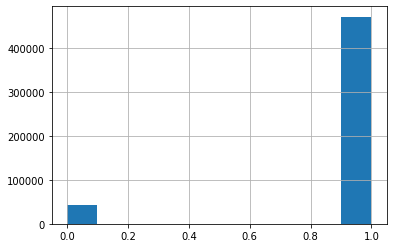

In [24]:
X['EMPSTAT'] = [1 if x == 1 else 0 for x in X['EMPSTAT']]
X['EMPSTAT'].hist()

## UHRSWORK
Do not need changes

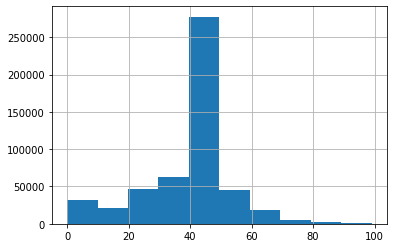

In [25]:
X['UHRSWORK'].hist()

## DIFFREM: 0, DIFFPHYS 0, VETSTAT 0

No N/A terms

In [26]:
X['DIFFREM'].describe()

count    514548.000000
mean          1.013847
std           0.116856
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: DIFFREM, dtype: float64

In [27]:
X['DIFFPHYS'].describe()

count    514548.000000
mean          1.013785
std           0.116597
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: DIFFPHYS, dtype: float64

In [28]:
X['VETSTAT'].describe()

count    514548.000000
mean          1.022575
std           0.148545
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: VETSTAT, dtype: float64

## YRSUSA1
We will drop this feature for not being clear on the coding

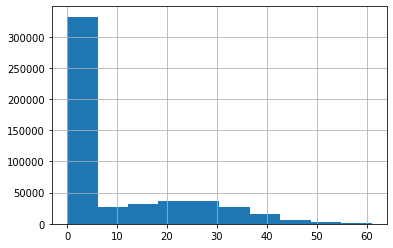

In [29]:
X['YRSUSA1'].hist()

## HCOVANY
change to 0 => no insurance, 1 => has insurance

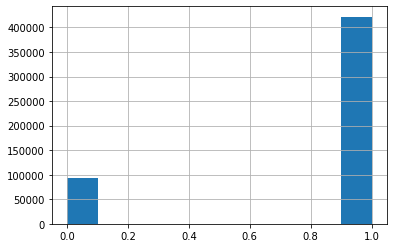

In [30]:
X['HCOVANY'] -= 1
X['HCOVANY'].hist()

## DIFFREM, DIFFPHYS, DIFFEYE, DIFFHEAR, VETSTAT

Set 0 as no, 1 as yes

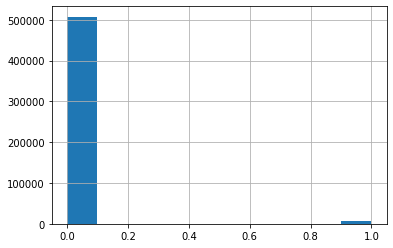

In [31]:
X[['DIFFREM', 'DIFFPHYS', 'DIFFEYE', 'DIFFHEAR', 'VETSTAT']] -= 1
X['DIFFREM'].hist()

In [32]:
print(X.columns)

Index(['YEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'STATEICP',
       'COUNTYICP', 'STRATA', 'GQ', 'PERNUM', 'PERWT', 'FAMSIZE', 'SEX', 'AGE',
       'MARST', 'FERTYR', 'RACE', 'RACED', 'BPL', 'BPLD', 'CITIZEN', 'YRSUSA1',
       'SPEAKENG', 'HCOVANY', 'EDUC', 'EMPSTAT', 'EMPSTATD', 'UHRSWORK',
       'INCWAGE', 'DIFFREM', 'DIFFPHYS', 'DIFFEYE', 'DIFFHEAR', 'VETSTAT',
       'VETSTATD', 'INC_AVG', 'INC_INDEX', 'EDU_ATT', 'DIPLOMA'],
      dtype='object')


In [33]:
final_df = X[['SEX', 'AGE','MARST', 'FERTYR', 'RACE', 'CITIZEN',
       'SPEAKENG', 'HCOVANY', 'EMPSTAT', 'UHRSWORK', 'DIFFREM', 
       'DIFFPHYS', 'DIFFEYE', 'DIFFHEAR', 'VETSTAT',
        'EDU_ATT', 'DIPLOMA', 'INC_INDEX']]

In [34]:
final_df.to_csv('/content/drive/Shareddrives/DSCI531/modeling/cleaned_data.csv'
                , index = False)